In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from astropy.cosmology import Planck18 as cosmo

In [18]:
ROOT_DIR = r'C:\Users\jgmad\Research\Ibn'
DATA_DIR =  os.path.join(ROOT_DIR, "data")
summary_file, = glob(os.path.join(DATA_DIR, "ZTFBTS_summary.csv"))
summary_data = pd.read_csv(summary_file)
summary_data.replace('-', np.nan, inplace=True)

mean - mean values in each filter
log_scale_short- log of the short-duration variability timescale of the light curve (typical across all bands)
log_scale_long- log of the long-duration variability timescale of the light curve (typical across all bands)
log_diagonal_short- diagonal terms of the covariance matrix corresponding to the short-duration variability (connected to the strength of the short-duration variability in each filter)
off_diagonal_short- off-diagonal terms of the band-wise covariance matrix corresponding to the short-duration variability (connected to the strength of the correlation across filters)
log_diagonal_long- diagonal terms of the covariance matrix corresponding to the long-duration variability (connected to the strength of the long-duration variability in each filter)
off_diagonal_long- off-diagonal terms of the band-wise covariance matrix corresponding to the long-duration variability (connected to the strength of the correlation across filters)
log_jitter - an extra noise term to account for any additional scatter not captured by the reported uncertainties
Happy to discuss any of these in more detail at our next meeting!

In [19]:
DAYS_AFTER = 0
param_file, = glob(os.path.join(DATA_DIR, f"gp_params_SN_all{'_' + str(DAYS_AFTER) if DAYS_AFTER else ''}.csv"))
# ibn_param_file, = glob(os.path.join(DATA_DIR, f"gp_params_SN_Ibn_all{'_' + str(DAYS_AFTER) if DAYS_AFTER else ''}.csv"))

params_of_interest = ['supernova_name','mean_g','mean_r','log_diagonal_short_r','log_diagonal_short_g','log_diagonal_long_r','log_diagonal_long_g','log_scale_long','log_scale_short'] + ['off_diagonal_short','off_diagonal_long'] + ['color_mean','color_at_peak','color_min_time','color_max_time']

df = pd.read_csv(param_file)
df = df[params_of_interest]
# df_ibn = pd.read_csv(ibn_param_file)

print(df)

      supernova_name    mean_g    mean_r  log_diagonal_short_r  \
0       ZTF22abitewv  2.297003  3.025410              0.853666   
1       ZTF21abnuldi  2.906223  1.937112             -3.189152   
2       ZTF18acvwdkk  4.037726  4.326286             -5.457004   
3       ZTF20acuobve       NaN       NaN                   NaN   
4       ZTF22abtdarf  5.527312  5.640794             -5.037170   
...              ...       ...       ...                   ...   
10579         2014av  3.780495  4.225048             -4.937745   
10580          2015U  1.667251  1.908018              2.369113   
10581       iPTF15ul  0.839753  0.904617              1.693661   
10582       PTF11rfh  3.911291  4.318051             -5.561965   
10583        2018jmt -0.865377  0.557511              2.474832   

       log_diagonal_short_g  log_diagonal_long_r  log_diagonal_long_g  \
0                 -6.502063            -5.557482            -6.579567   
1                 -6.591555             1.707803           -1

In [20]:

#summary_data.set_index('ZTFID', inplace=True)

lookup_dict = dict(zip(summary_data['ZTFID'], summary_data['type'] == 'SN Ibn'))
z_dict = dict(zip(summary_data['ZTFID'], summary_data['redshift']))
type_dict = dict(zip(summary_data['ZTFID'], summary_data['type']))

df = df.rename(columns={'oid':'supernova_name'})
#df = df.drop(['oid_r','oid_g'],axis=1)

#df['first_det'] = df[['first_det_r','first_det_g']].min(axis=1)

df['Ibn'] = df['supernova_name'].map(lookup_dict)
df['redshift'] = df['supernova_name'].map(z_dict).astype(float)

df = df[~df['supernova_name'].map(type_dict).isnull()] # For now only labeled dataset
print(f'Before redshift cut: {len(df)}')
df = df[~df['redshift'].isnull()]
df = df[df['redshift'] > 0]
print(f'After redshift cut {len(df)}')


Before redshift cut: 10584
After redshift cut 10582


In [21]:
print(f'Before mean cut: {len(df)}')
df = df.dropna(subset=['mean_r','mean_g'])
print(f'After mean cut: {len(df)}')

Before mean cut: 10582
After mean cut: 9996


In [22]:
df_ibn = df[df['supernova_name'].isin(summary_data[summary_data['type'] == 'SN Ibn']['ZTFID'])].copy()

# split by Ibn

df_rest = df[df['Ibn'] == False]
print('Before',len(df))
print('After',len(df_rest))
print('Ibn',len(df_ibn))
df_ibn

Before 9996
After 9942
Ibn 54


,supernova_name,mean_g,mean_r,log_diagonal_short_r,log_diagonal_short_g,log_diagonal_long_r,log_diagonal_long_g,log_scale_long,log_scale_short,off_diagonal_short,off_diagonal_long,color_mean,color_at_peak,color_min_time,color_max_time,Ibn,redshift
50,ZTF25aaompnz,3.851761,4.227468,0.506190,-5.464847,-6.309338,-6.955751,11.009077,3.541515,2.075696,0.001039,0.032092,-0.076434,0.000000,10.346962,True,0.060000
445,ZTF19acrwyyb,5.311406,5.138698,-0.011441,-5.340796,-5.948977,-5.691328,11.861624,3.704061,1.531471,0.000473,0.203514,0.300624,5.742963,0.000000,True,0.052000
575,ZTF23aajhtuu,4.816433,4.564555,0.495258,-6.837067,-6.134274,-6.915709,20.867211,3.927915,1.727062,0.000815,0.247679,0.260603,5.426614,0.000000,True,0.103000
884,ZTF19acmbekd,3.525931,3.904067,0.217287,-7.348248,-6.082148,-5.545928,10.906754,2.908327,2.286672,0.001199,0.171979,0.317447,0.000000,6.162450,True,0.050000
1115,ZTF21aauvmck,3.748187,3.723646,0.551229,-7.109223,-4.830182,-5.783193,12.360591,3.288467,1.981340,0.004585,0.116493,0.143030,11.561764,0.580993,True,0.038000
1305,ZTF24abiesnr,4.436828,4.394928,0.578482,-7.124862,-5.482807,-6.721507,15.764616,3.588984,1.584162,0.001617,-0.089664,0.051546,17.711819,0.000000,True,0.066000
1495,ZTF19aapfmki,3.839990,3.548815,1.301475,-7.009972,-4.758235,-6.564550,15.858636,4.246476,3.357670,0.007758,0.224117,0.096212,0.000000,27.416155,True,0.054690
1580,ZTF20abfadah,2.406351,2.164345,-6.955774,-7.409153,1.403694,-4.464068,5.454257,15.653054,0.001048,3.598462,-0.027634,-0.027672,34.845227,0.000000,True,0.100000
2316,ZTF21achujxq,5.352892,5.184496,-2.497465,-5.535482,1.950660,-7.600746,5.781120,12.904940,0.060580,5.393700,0.456029,0.122787,0.000000,46.847814,True,0.023480
2397,ZTF21aatwkkt,3.932620,4.056467,-0.329627,-10.381124,-34.800133,-36.631750,38.368716,2.863742,0.742549,-0.010464,0.187471,-0.003475,0.000000,14.856598,True,0.071200


In [23]:
print(df.columns)

Index(['supernova_name', 'mean_g', 'mean_r', 'log_diagonal_short_r',
       'log_diagonal_short_g', 'log_diagonal_long_r', 'log_diagonal_long_g',
       'log_scale_long', 'log_scale_short', 'off_diagonal_short',
       'off_diagonal_long', 'color_mean', 'color_at_peak', 'color_min_time',
       'color_max_time', 'Ibn', 'redshift'],
      dtype='object')


In [24]:
# Count NaN values per column
rest_nan_counts = df_rest.isnull().sum()

print('Non Ibn:')
for a,b in rest_nan_counts.items():
    print(a,b)

print('before',len(df_rest))
df_rest_filtered = df_rest[~((df_rest['mean_g'].isnull()) & (df_rest['mean_r'].isnull()))].copy() # drop where both g and r are empty
print('after',len(df_rest_filtered))

# Count NaN values per column
ibn_nan_counts = df_ibn.isnull().sum()

print('Ibn:')
for a,b in ibn_nan_counts.items():
    print(a,b)

print('before',len(df_ibn))
df_ibn_filtered = df_ibn[~((df_ibn['mean_g'].isnull()) & (df_ibn['mean_r'].isnull()))].copy() # drop where both g and r are empty
print('after',len(df_ibn_filtered))

Non Ibn:
supernova_name 0
mean_g 0
mean_r 0
log_diagonal_short_r 0
log_diagonal_short_g 0
log_diagonal_long_r 0
log_diagonal_long_g 0
log_scale_long 0
log_scale_short 0
off_diagonal_short 0
off_diagonal_long 0
color_mean 0
color_at_peak 0
color_min_time 0
color_max_time 0
Ibn 0
redshift 0
before 9942
after 9942
Ibn:
supernova_name 0
mean_g 0
mean_r 0
log_diagonal_short_r 0
log_diagonal_short_g 0
log_diagonal_long_r 0
log_diagonal_long_g 0
log_scale_long 0
log_scale_short 0
off_diagonal_short 0
off_diagonal_long 0
color_mean 0
color_at_peak 0
color_min_time 0
color_max_time 0
Ibn 0
redshift 0
before 54
after 54


In [25]:
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

def gen_points(feature_x,feature_y,df1=df_rest_filtered,df2=df_ibn_filtered):
    #df1 = remove_outliers_iqr(df1,[feature_x,feature_y])
    x = df1[feature_x].astype(float)
    y = df1[feature_y].astype(float)

    #df2 = remove_outliers_iqr(df2,[feature_x,feature_y])
    xi = df2[feature_x].astype(float)
    yi = df2[feature_y].astype(float)
    return x,y,xi,yi

In [26]:
df_rest_filtered['Ibn'] = 0
df_ibn_filtered['Ibn'] = 1

full = pd.concat([df_rest_filtered,df_ibn_filtered],ignore_index=True)
full = full.drop_duplicates(subset=['supernova_name']).reset_index(drop=True)
# 
#  = full.drop('supernova_name',axis=1)
# full['Ibn'] = full['Ibn'].map({True:1,False:0}) # Map from boolean to int

# full = full.drop(['log_jitter_r','log_jitter_g'],axis=1)
print(full.head())

cols_to_convert = [c for c in df.columns if c not in ['supernova_name','Ibn']]

# Convert them to float
full[cols_to_convert] = full[cols_to_convert].apply(pd.to_numeric, errors='coerce')

  supernova_name    mean_g    mean_r  log_diagonal_short_r  \
0   ZTF22abitewv  2.297003  3.025410              0.853666   
1   ZTF21abnuldi  2.906223  1.937112             -3.189152   
2   ZTF18acvwdkk  4.037726  4.326286             -5.457004   
3   ZTF22abtdarf  5.527312  5.640794             -5.037170   
4   ZTF18abolvoh  5.034644  5.073470              0.435856   

   log_diagonal_short_g  log_diagonal_long_r  log_diagonal_long_g  \
0             -6.502063            -5.557482            -6.579567   
1             -6.591555             1.707803           -11.062608   
2             -3.635489            -2.305204            -4.431565   
3            -77.982393             0.157573          -677.413116   
4             -9.263132            -7.363635            -7.487761   

   log_scale_long  log_scale_short  off_diagonal_short  off_diagonal_long  \
0        9.632749         3.965994            2.863750           0.003669   
1        4.334601         9.499089            0.026587    

  supernova_name    mean_g    mean_r  log_diagonal_short_r  \
0   ZTF22abitewv  2.297003  3.025410              0.853666   
1   ZTF21abnuldi  2.906223  1.937112             -3.189152   
2   ZTF18acvwdkk  4.037726  4.326286             -5.457004   
3   ZTF22abtdarf  5.527312  5.640794             -5.037170   
4   ZTF18abolvoh  5.034644  5.073470              0.435856   

   log_diagonal_short_g  log_diagonal_long_r  log_diagonal_long_g  \
0             -6.502063            -5.557482            -6.579567   
1             -6.591555             1.707803           -11.062608   
2             -3.635489            -2.305204            -4.431565   
3            -77.982393             0.157573          -677.413116   
4             -9.263132            -7.363635            -7.487761   

   log_scale_long  log_scale_short  off_diagonal_short  off_diagonal_long  \
0        9.632749         3.965994            2.863750           0.003669   
1        4.334601         9.499089            0.026587    

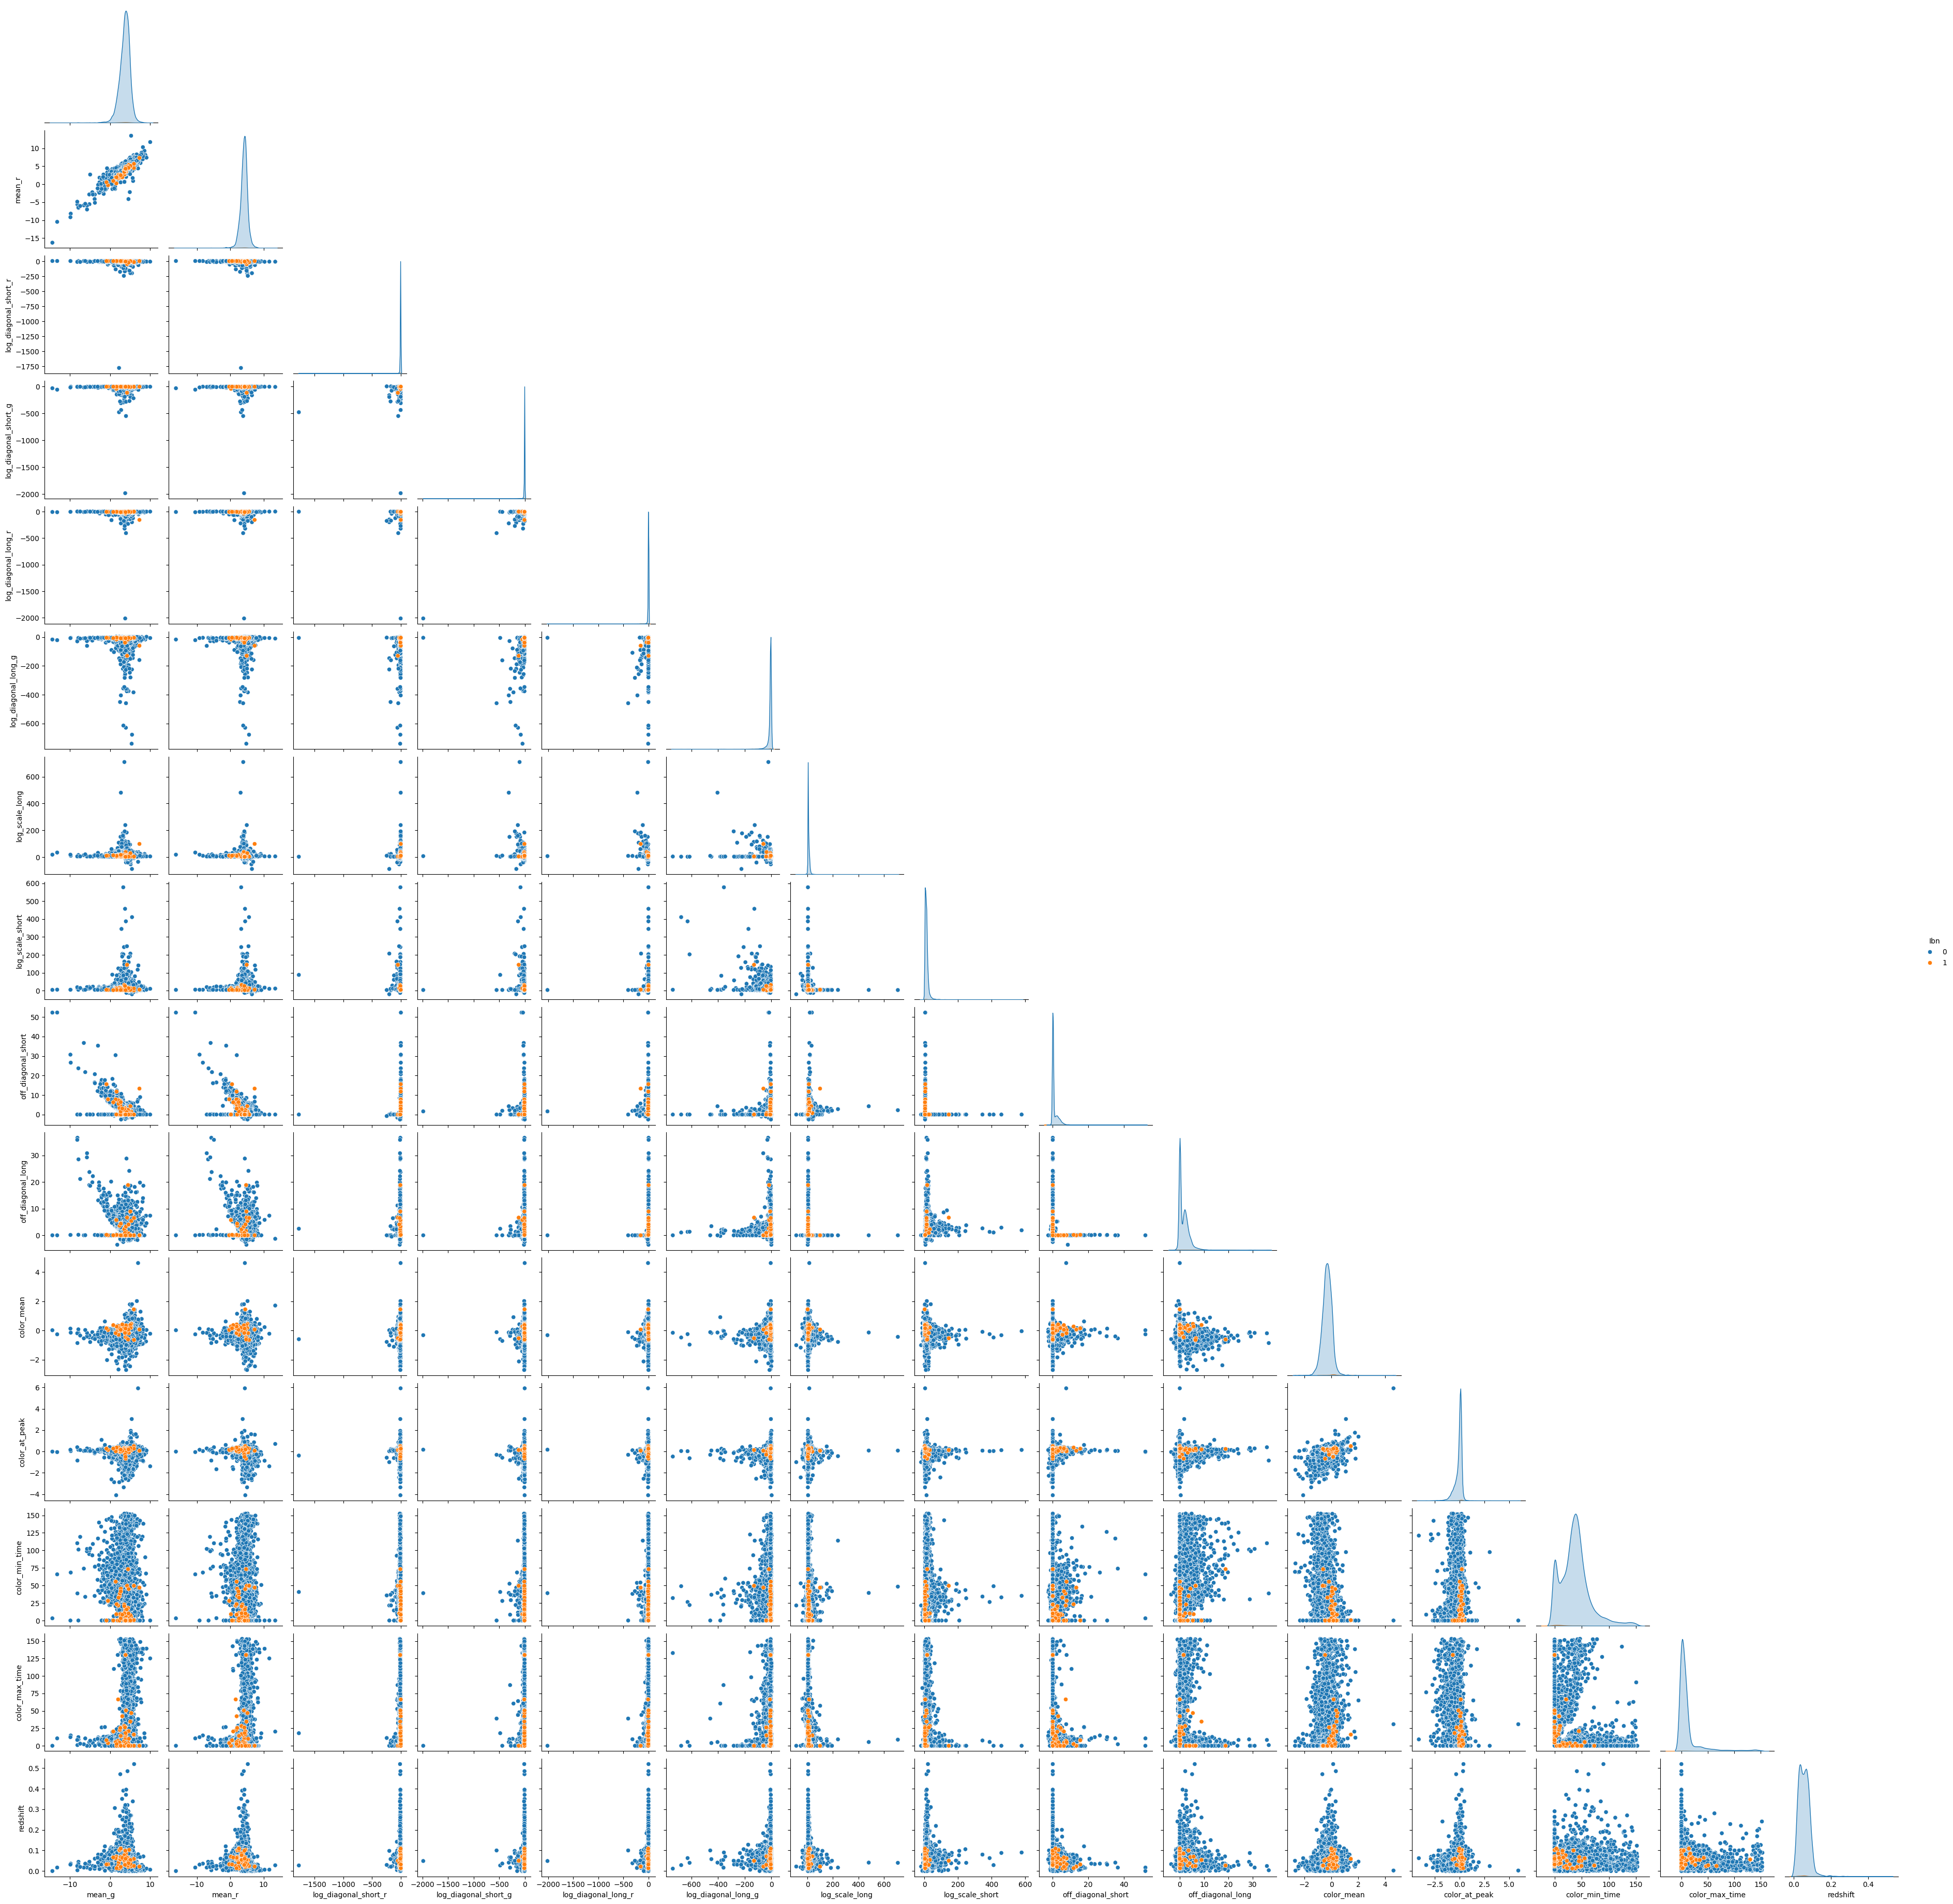

In [27]:
import seaborn as sns
# full['Ibn']
penguins = sns.load_dataset("penguins")
print(full.head())
print(full.info())
sns.pairplot(full,hue='Ibn',corner=True)

In [28]:
ds = ['log_diagonal_long_r','log_diagonal_long_g']
x = []

#x.extend([s for s in df[df['log_diagonal_long_r'] < -200]['supernova_name']])
for d in ds:
    x.extend([s for s in full[full[d] < -200]['supernova_name']])
print(x)

['ZTF25aabzbve', 'ZTF22abyrovo', 'ZTF23aaijkwo', 'ZTF20abeeahl', 'ZTF19aayrosj', 'ZTF18acsohut', 'ZTF25aaixenf', 'ZTF22abtdarf', 'ZTF20aambbfn', 'ZTF25aarnyuv', 'ZTF18accrorf', 'ZTF18acvwchp', 'ZTF24aaekblj', 'ZTF23abhyroo', 'ZTF25aabzbve', 'ZTF18aafdigb', 'ZTF20acoxtxr', 'ZTF21aafepon', 'ZTF22abyrovo', 'ZTF20acotwur', 'ZTF24aaxvjcx', 'ZTF19aazgpar', 'ZTF20abblqtl', 'ZTF24aatifzm', 'ZTF24aalsuwb', 'ZTF24aaahbvh', 'ZTF19aayrosj', 'ZTF18acsohut', 'ZTF19aapreza', 'ZTF21aaabzdr', 'ZTF23aaahegu', 'ZTF19acgjosf', 'ZTF25aaixenf']


In [29]:
# Want to impute at least mean_r and mean_g

full['mean_r'] = full['mean_r'].fillna(full['mean_r'].mean())
full['mean_g'] = full['mean_g'].fillna(full['mean_g'].mean())
full.columns

Index(['supernova_name', 'mean_g', 'mean_r', 'log_diagonal_short_r',
       'log_diagonal_short_g', 'log_diagonal_long_r', 'log_diagonal_long_g',
       'log_scale_long', 'log_scale_short', 'off_diagonal_short',
       'off_diagonal_long', 'color_mean', 'color_at_peak', 'color_min_time',
       'color_max_time', 'Ibn', 'redshift'],
      dtype='object')

In [30]:
# Train Test Split
# full = full[['mean_g,']]
'''
X = full.drop('Ibn',axis=1)
y = full['Ibn']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y,random_state=12282005)
print(X_train)
'''

unique_SN = full['supernova_name'].unique()

SN_to_type = dict(zip(full['supernova_name'], full['Ibn']))
types = [SN_to_type[SN] for SN in unique_SN]

train_SN,test_SN = train_test_split(unique_SN,stratify=types,test_size=0.2,random_state=12282005)

train_mask = full['supernova_name'].isin(train_SN)
test_mask = ~train_mask

features = ['mean_g', 'mean_r', 'log_diagonal_short_r',
       'log_diagonal_short_g', 'log_diagonal_long_r', 'log_diagonal_long_g',
       'off_diagonal_short', 'off_diagonal_long', 'log_scale_long', 'log_scale_short'] + ['color_mean','color_at_peak','color_min_time','color_max_time'] + ['redshift']

X_train = full[train_mask][features]
y_train = full[train_mask]['Ibn']

X_test = full[test_mask][features]
y_test = full[test_mask]['Ibn']

Now let's try to SMOTE

In [31]:
'''# import seaborn as sns

X_train_resampled_labeled = X_train_resampled.copy()

conditions = [
    ~X_train_resampled.isin(X_train.to_dict('list')).all(axis=1),  # Is SMOTE data
    X_train_resampled.isin(df_ibn.to_dict('list')).all(axis=1) # Is Ibn
]

X_train_resampled_labeled['hue'] = np.select(conditions,['SMOTE','Ibn'],default='Non-Ibn')

print(X_train_resampled_labeled['hue'].value_counts())
print(X_train_resampled_labeled.info())
sns.pairplot(X_train_resampled_labeled,hue='hue',palette=['blue','red','orange'],corner=True)'''

"# import seaborn as sns\n\nX_train_resampled_labeled = X_train_resampled.copy()\n\nconditions = [\n    ~X_train_resampled.isin(X_train.to_dict('list')).all(axis=1),  # Is SMOTE data\n    X_train_resampled.isin(df_ibn.to_dict('list')).all(axis=1) # Is Ibn\n]\n\nX_train_resampled_labeled['hue'] = np.select(conditions,['SMOTE','Ibn'],default='Non-Ibn')\n\nprint(X_train_resampled_labeled['hue'].value_counts())\nprint(X_train_resampled_labeled.info())\nsns.pairplot(X_train_resampled_labeled,hue='hue',palette=['blue','red','orange'],corner=True)"

In [36]:
# OPTIMIZING FOR F BETA SCORE 

# Try to tune parameters using optuna

import optuna
from lightgbm import LGBMClassifier,early_stopping, log_evaluation
from sklearn.metrics import fbeta_score #f1_score,recall_score
from sklearn.model_selection import train_test_split,StratifiedKFold,LeaveOneOut

import warnings
warnings.filterwarnings("ignore")

optuna.logging.set_verbosity(optuna.logging.FATAL)

from imblearn.over_sampling import SMOTE

alpha = 1/2 # 1/beta

full = full.drop_duplicates(subset=['supernova_name']).reset_index(drop=True)

X = full[features]
y = full['Ibn']

# Define objective function for Optuna
def objective_fn(trial):
    sampling_strategy = trial.suggest_uniform('sampling_strategy', 0.3, 1.0)
    threshold = trial.suggest_uniform('threshold', 0.05, 0.95)

    #focal_obj  = focal_loss_lgb(alpha, gamma)
    #focal_eval = focal_loss_eval(alpha, gamma)

    params = {
        'class_weight': 'balanced',
        'n_estimators': 300,
        #'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'learning_rate':0.01,
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'random_state': 12282005,
        'verbosity':-1,
        #'objective':focal_obj
    }

    # want to do training and validation over sum(y) different splits OR now since just tuning, maybe can just do 5 fold validation 
    #print(sum(y))

    splitting = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=12282005
    )
    #splitting = LeaveOneOut()
    mscores = []
    scores = []

    sm = SMOTE(random_state=12282005,sampling_strategy=sampling_strategy)

    # We have to apply SMOTE within each fold so we start with X and y

    for train_idx,val_idx in splitting.split(X,y):
        X_train_fold,y_train_fold,X_val_fold,y_val_fold = X.iloc[train_idx],y.iloc[train_idx],X.iloc[val_idx],y.iloc[val_idx]

        X_train_fold_resampled,y_train_fold_resampled = sm.fit_resample(X_train_fold,y_train_fold)
        #X_train_fold_resampled,y_train_fold_resampled = X_train_fold,y_train_fold

        model = LGBMClassifier(**params)

        model.fit(
            X_train_fold_resampled, y_train_fold_resampled,
            eval_set=[(X_val_fold, y_val_fold)],
            #eval_metric=focal_eval,
            callbacks=[early_stopping(5)]
        )

        y_probs = model.predict_proba(X_val_fold)[:, 1]
        y_pred = (y_probs >= threshold).astype(int) 
        #score = f1_score(y_test, y_pred, average='binary')  # Focus on class 1
        if alpha:
            score = fbeta_score(y_val_fold, y_pred, beta=1/alpha, pos_label=1, average='binary')  # Focus on class 1 (Ibn)
            mscore = recall_score(y_val_fold, y_pred,pos_label=1,average='binary')
        else:
            mscore = fbeta_score(y_val_fold, y_pred, beta=2, pos_label=1, average='binary')  # Focus on class 1 (Ibn)
            score = recall_score(y_val_fold, y_pred,pos_label=1,average='binary')
        mscores.append(mscore)
        scores.append(score)

    scores_mean = np.mean(scores)
    scroes_std  = np.std(scores, ddof=1)
    trial.set_user_attr('sampling_strategy', sampling_strategy)
    trial.set_user_attr('threshold', threshold)
    #trial.set_user_attr('alpha', alpha)
    #trial.set_user_attr('gamma', gamma)
    trial.set_user_attr('scores_std', float(scroes_std))
    return scores_mean

# Run Optuna optimization
study = optuna.create_study(direction='maximize')

'''initial_params = {
    'sampling_strategy': 0.9332037435470149,
    'threshold': 0.06277550248785539,
    'learning_rate': 0.06940600855324495,
    'num_leaves': 26,
    'max_depth': 4,
    'min_child_samples': 84,
    'reg_alpha': 0.2662044019333212,
    'reg_lambda': 0.09337327992988727,
    'subsample': 0.6666028791233275,
    'colsample_bytree': 0.6652640151318506

}

study.enqueue_trial(initial_params)'''
study.optimize(objective_fn, n_trials=100, n_jobs = 5)

# Best params and model
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print(f"Standard Deviation: {study.best_trial.user_attrs['scores_std']}")
print(f"  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

# ---

54
54
54
54
54
Training until validation scores don't improve for 5 roundsTraining until validation scores don't improve for 5 rounds

Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.16203
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.101912
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.193748
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.165341
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.0819559


In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Get best params from study
best_params = study.best_trial.params

# Add necessary fixed parameters
best_params.update({
    'class_weight': 'balanced',
    'n_estimators': 1000,
    'random_state': 12282005,
    #'objective':focal_loss_lgb(study.best_trial.user_attrs['alpha'],study.best_trial.user_attrs['gamma'])
})

# Initialize model
lgbm = LGBMClassifier(**best_params)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    stratify=y_train,
    test_size=0.2,
    random_state=12282005
)

sm = SMOTE(random_state=12282005,sampling_strategy=study.best_trial.user_attrs['sampling_strategy'])
X_train_resampled,y_train_resampled = sm.fit_resample(X_tr,y_tr)

lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(100),log_evaluation(0)]
)

# Predict
y_probs = lgbm.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= study.best_trial.user_attrs['threshold']).astype(int) 

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

results_csv_file = os.path.join(DATA_DIR, "interpretable_results.csv")
header_fields = ['MODEL','METRIC','SC0RE','STD','DAYS_AFTER']
file_exists = os.path.exists(results_csv_file)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0295561
Accuracy: 0.992
Confusion Matrix:
[[1981    8]
 [   8    3]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9960    0.9960    0.9960      1989
           1     0.2727    0.2727    0.2727        11

    accuracy                         0.9920      2000
   macro avg     0.6344    0.6344    0.6344      2000
weighted avg     0.9920    0.9920    0.9920      2000



In [34]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import make_pipeline
from sklearn.metrics import recall_score, precision_score
import numpy as np

try:
    best_threshold = best_params.pop('threshold')  # Extract threshold separately
    print(best_threshold)
except KeyError:
    pass

try:
    sampling_strategy = best_params.pop('sampling_strategy')
    print(sampling_strategy)
except KeyError:
    pass

# 1) Reconstruct your best‐param model
best_params.update({
    'class_weight': 'balanced',
    'n_estimators':   1000,
    'random_state':   12282005,
})

clf = LGBMClassifier(**best_params)
sm = SMOTE(random_state=12282005,sampling_strategy=sampling_strategy)

# 3) Define the same CV splitter you used in Optuna
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=6301994)

recalls = []
precisions = []
fprs = []
conf_matrices = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

    model = LGBMClassifier(**best_params)
    model.fit(X_train_resampled, y_train_resampled)

    y_probs = model.predict_proba(X_val)[:, 1]
    y_pred_fold = (y_probs >= best_threshold).astype(int)

    recall = recall_score(y_val, y_pred_fold)
    precision = precision_score(y_val,y_pred_fold)
    cm = confusion_matrix(y_val, y_pred_fold)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_fold).ravel()

    recalls.append(recall)
    precisions.append(precision)
    conf_matrices.append(cm)
    fprs.append(fp/(tn+fp))

    print(f"\nFold {fold+1} Confusion Matrix:\n{cm}")
    print(f"Recall: {recall:.4f}")

print("\nRecall per fold:", recalls)
print("\nPrecisions per fold:", precisions)
print("Mean recall:   ", np.mean(recalls))
print("Mean precision:   ", np.mean(precisions))
print("STD of recall: ", np.std(recalls, ddof=1))
print("STD of precision: ", np.std(precisions, ddof=1))
print("Mean FPR:   ", np.mean(fprs))
print("STD of FPR: ", np.std(fprs, ddof=1))

0.5034136204829212
0.5539481904755026

Fold 1 Confusion Matrix:
[[1971   18]
 [   9    2]]
Recall: 0.1818

Fold 2 Confusion Matrix:
[[1975   14]
 [   7    3]]
Recall: 0.3000

Fold 3 Confusion Matrix:
[[1966   22]
 [   8    3]]
Recall: 0.2727

Fold 4 Confusion Matrix:
[[1964   24]
 [   8    3]]
Recall: 0.2727

Fold 5 Confusion Matrix:
[[1979    9]
 [  10    1]]
Recall: 0.0909

Recall per fold: [0.18181818181818182, 0.3, 0.2727272727272727, 0.2727272727272727, 0.09090909090909091]

Precisions per fold: [0.1, 0.17647058823529413, 0.12, 0.1111111111111111, 0.1]
Mean recall:    0.22363636363636363
Mean precision:    0.12151633986928105
STD of recall:  0.08662639454233888
STD of precision:  0.03184510656413044
Mean FPR:    0.00875089653051542
STD of FPR:  0.0030518432746714694


In [35]:
import pandas as pd

# 1) Grab the test‐set names in the same order as X_test
#    (full[test_mask] was what you used to build X_test)
test_names = full.loc[test_mask, 'supernova_name'].reset_index(drop=True)
# 2) Build a small results DataFrame aligned by position

results = pd.DataFrame({
    'supernova_name': test_names,
    'y_true':         y_test.reset_index(drop=True),
    'y_test_pred':         y_test_pred
})

print(len(test_names),len(X_test),len(y_test))

# 3) Filter to the true Ibn’s (y_true==1) that were predicted 0
missed = results[(results.y_true == 1) & (results.y_test_pred == 0)]


# 4) Save the unique supernova names you missed
missed['supernova_name'] \
    .drop_duplicates() \
    .to_csv('misclassified_not_Ibn.csv', index=False)

print(
    f"Total mis‐classified rows: {len(missed)}\n"
    f"Unique Ibn’s missed   : {missed['supernova_name'].nunique()}\n"
    "Names written to misclassified_not_Ibn.csv"
)

missed_names = list(missed['supernova_name'])

NameError: name 'y_test_pred' is not defined

Remove ZTF20aalrqbu from training/test

Gain: How much that feature reduced the loss function by

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

perm = PermutationImportance(lgbm,scoring=None, n_iter=1, random_state=42, cv=None, refit=False).fit(X_train_resampled, y_train_resampled,)
tmp = eli5.show_weights(perm)
display(eli5.show_weights(perm, top = len(list(X_train_resampled.columns)), feature_names = list(X_train_resampled.columns)))

Weight,Feature
0.1329 ± 0.0000,off_diagonal_short
0.0890 ± 0.0000,color_min_time
0.0811 ± 0.0000,color_mean
0.0349 ± 0.0000,off_diagonal_long
0.0125 ± 0.0000,log_diagonal_long_g
0.0109 ± 0.0000,redshift
0.0101 ± 0.0000,log_scale_long
0.0071 ± 0.0000,log_scale_short
0.0039 ± 0.0000,log_diagonal_short_g
0.0021 ± 0.0000,color_max_time


add new range parameter based on fitted gp parameters

interpolate at higher cadence than observations

~50-100 times

team up with people to do cases together

be able to summarize the prompt given

clarifying questions
- imagine having 30 seconds with the CEO of the company, what is the most important crucial thing you need to know that only they can answer
- mission critical

framework
- imagine bcg project leader
- what are key questions (must be mission critical)
- e.g. biodiversity project - are all locations equal priority (e.g. Uganda more prone to fire so prioritize that)

brainstorming
- e.g. uganda ecotourism
- not sufficient to have a few good ideas
- idea list that can generate methodologies etc

chart reading
- articulate hypothesese
- explain why the sky is falling

case math
- tight strong organized structure
- be able to align with case manager

market sizing
- mostly bain
- can you quickly distill critical drivers
- sanity check, mechanics of what data is good what data is bad
- intellectual curiousity

case recipe
- 30 second interaction with CEO
- 

chatgpt
dont use chatgpt for frameworks
instead ask chatgpt all the drivers you could use to solve the problem


In [ ]:
team up with pe

Split Gain: How much that specific decision reduced the loss function by

Leaf Count: Number of rows/SN in that leaf

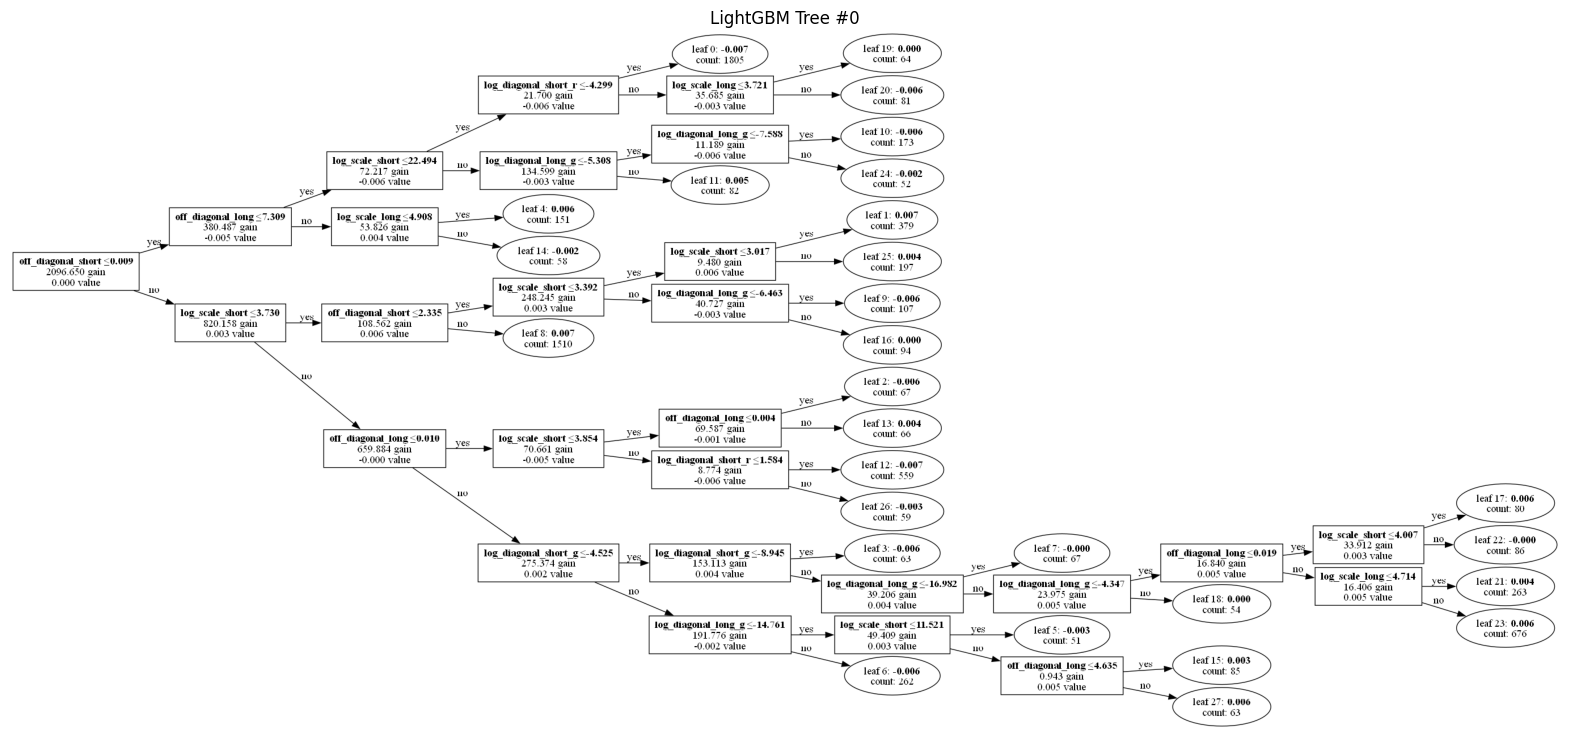

In [ ]:
from lightgbm import plot_tree

plot_tree(lgbm, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'leaf_count'])
plt.title("LightGBM Tree #0")
plt.show()

In [ ]:
def walk_tree(node, path=None):
    if path is None:
        path = []

    if 'split_index' in node:  # internal node
        feature = node['split_feature']
        threshold = node['threshold']
        gain = node['split_gain']
        left = node['left_child']
        right = node['right_child']

        # Add split to path and recurse
        walk_tree(left, path + [f"{feature} ≤ {threshold:.4f} (gain: {gain:.3f})"])
        walk_tree(right, path + [f"{feature} > {threshold:.4f} (gain: {gain:.3f})"])

    else:  # leaf node
        print(f"🟢 Leaf node:")
        print(f"   ➤ Path: {' → '.join(path)}")
        print(f"   ➤ Sample count: {node['leaf_count']}")
        print(f"   ➤ Internal value (log-odds): {node['leaf_value']:.4f}")
        print("")

# Load tree 0 from your model
tree_info = lgbm.booster_.dump_model()['tree_info'][0]
walk_tree(tree_info['tree_structure'])

🟢 Leaf node:
   ➤ Path: 6 ≤ 0.0085 (gain: 2096.650) → 7 ≤ 7.3087 (gain: 380.487) → 9 ≤ 22.4939 (gain: 72.217) → 2 ≤ -4.2986 (gain: 21.700)
   ➤ Sample count: 1805
   ➤ Internal value (log-odds): -0.0067

🟢 Leaf node:
   ➤ Path: 6 ≤ 0.0085 (gain: 2096.650) → 7 ≤ 7.3087 (gain: 380.487) → 9 ≤ 22.4939 (gain: 72.217) → 2 > -4.2986 (gain: 21.700) → 8 ≤ 3.7214 (gain: 35.685)
   ➤ Sample count: 64
   ➤ Internal value (log-odds): 0.0000

🟢 Leaf node:
   ➤ Path: 6 ≤ 0.0085 (gain: 2096.650) → 7 ≤ 7.3087 (gain: 380.487) → 9 ≤ 22.4939 (gain: 72.217) → 2 > -4.2986 (gain: 21.700) → 8 > 3.7214 (gain: 35.685)
   ➤ Sample count: 81
   ➤ Internal value (log-odds): -0.0065

🟢 Leaf node:
   ➤ Path: 6 ≤ 0.0085 (gain: 2096.650) → 7 ≤ 7.3087 (gain: 380.487) → 9 > 22.4939 (gain: 72.217) → 5 ≤ -5.3077 (gain: 134.599) → 5 ≤ -7.5880 (gain: 11.189)
   ➤ Sample count: 173
   ➤ Internal value (log-odds): -0.0064

🟢 Leaf node:
   ➤ Path: 6 ≤ 0.0085 (gain: 2096.650) → 7 ≤ 7.3087 (gain: 380.487) → 9 > 22.4939 (gain: 72

In [ ]:
len(full) == len(full.drop_duplicates('supernova_name'))

True

In [ ]:
# 1) turn your Series of names into Python sets for fast lookup
missed_names    = set(missed['supernova_name'])
test_names_set  = set(test_names)   # from full.loc[test_mask, 'supernova_name']

# 2) build the 3‐way status
conds = [
    df_ibn_filtered['supernova_name'].isin(missed_names),
    df_ibn_filtered['supernova_name'].isin(test_names_set),
]
choices = ['missed', 'correct']

df_ibn_filtered['status'] = np.select(conds, choices, default='not in test set')

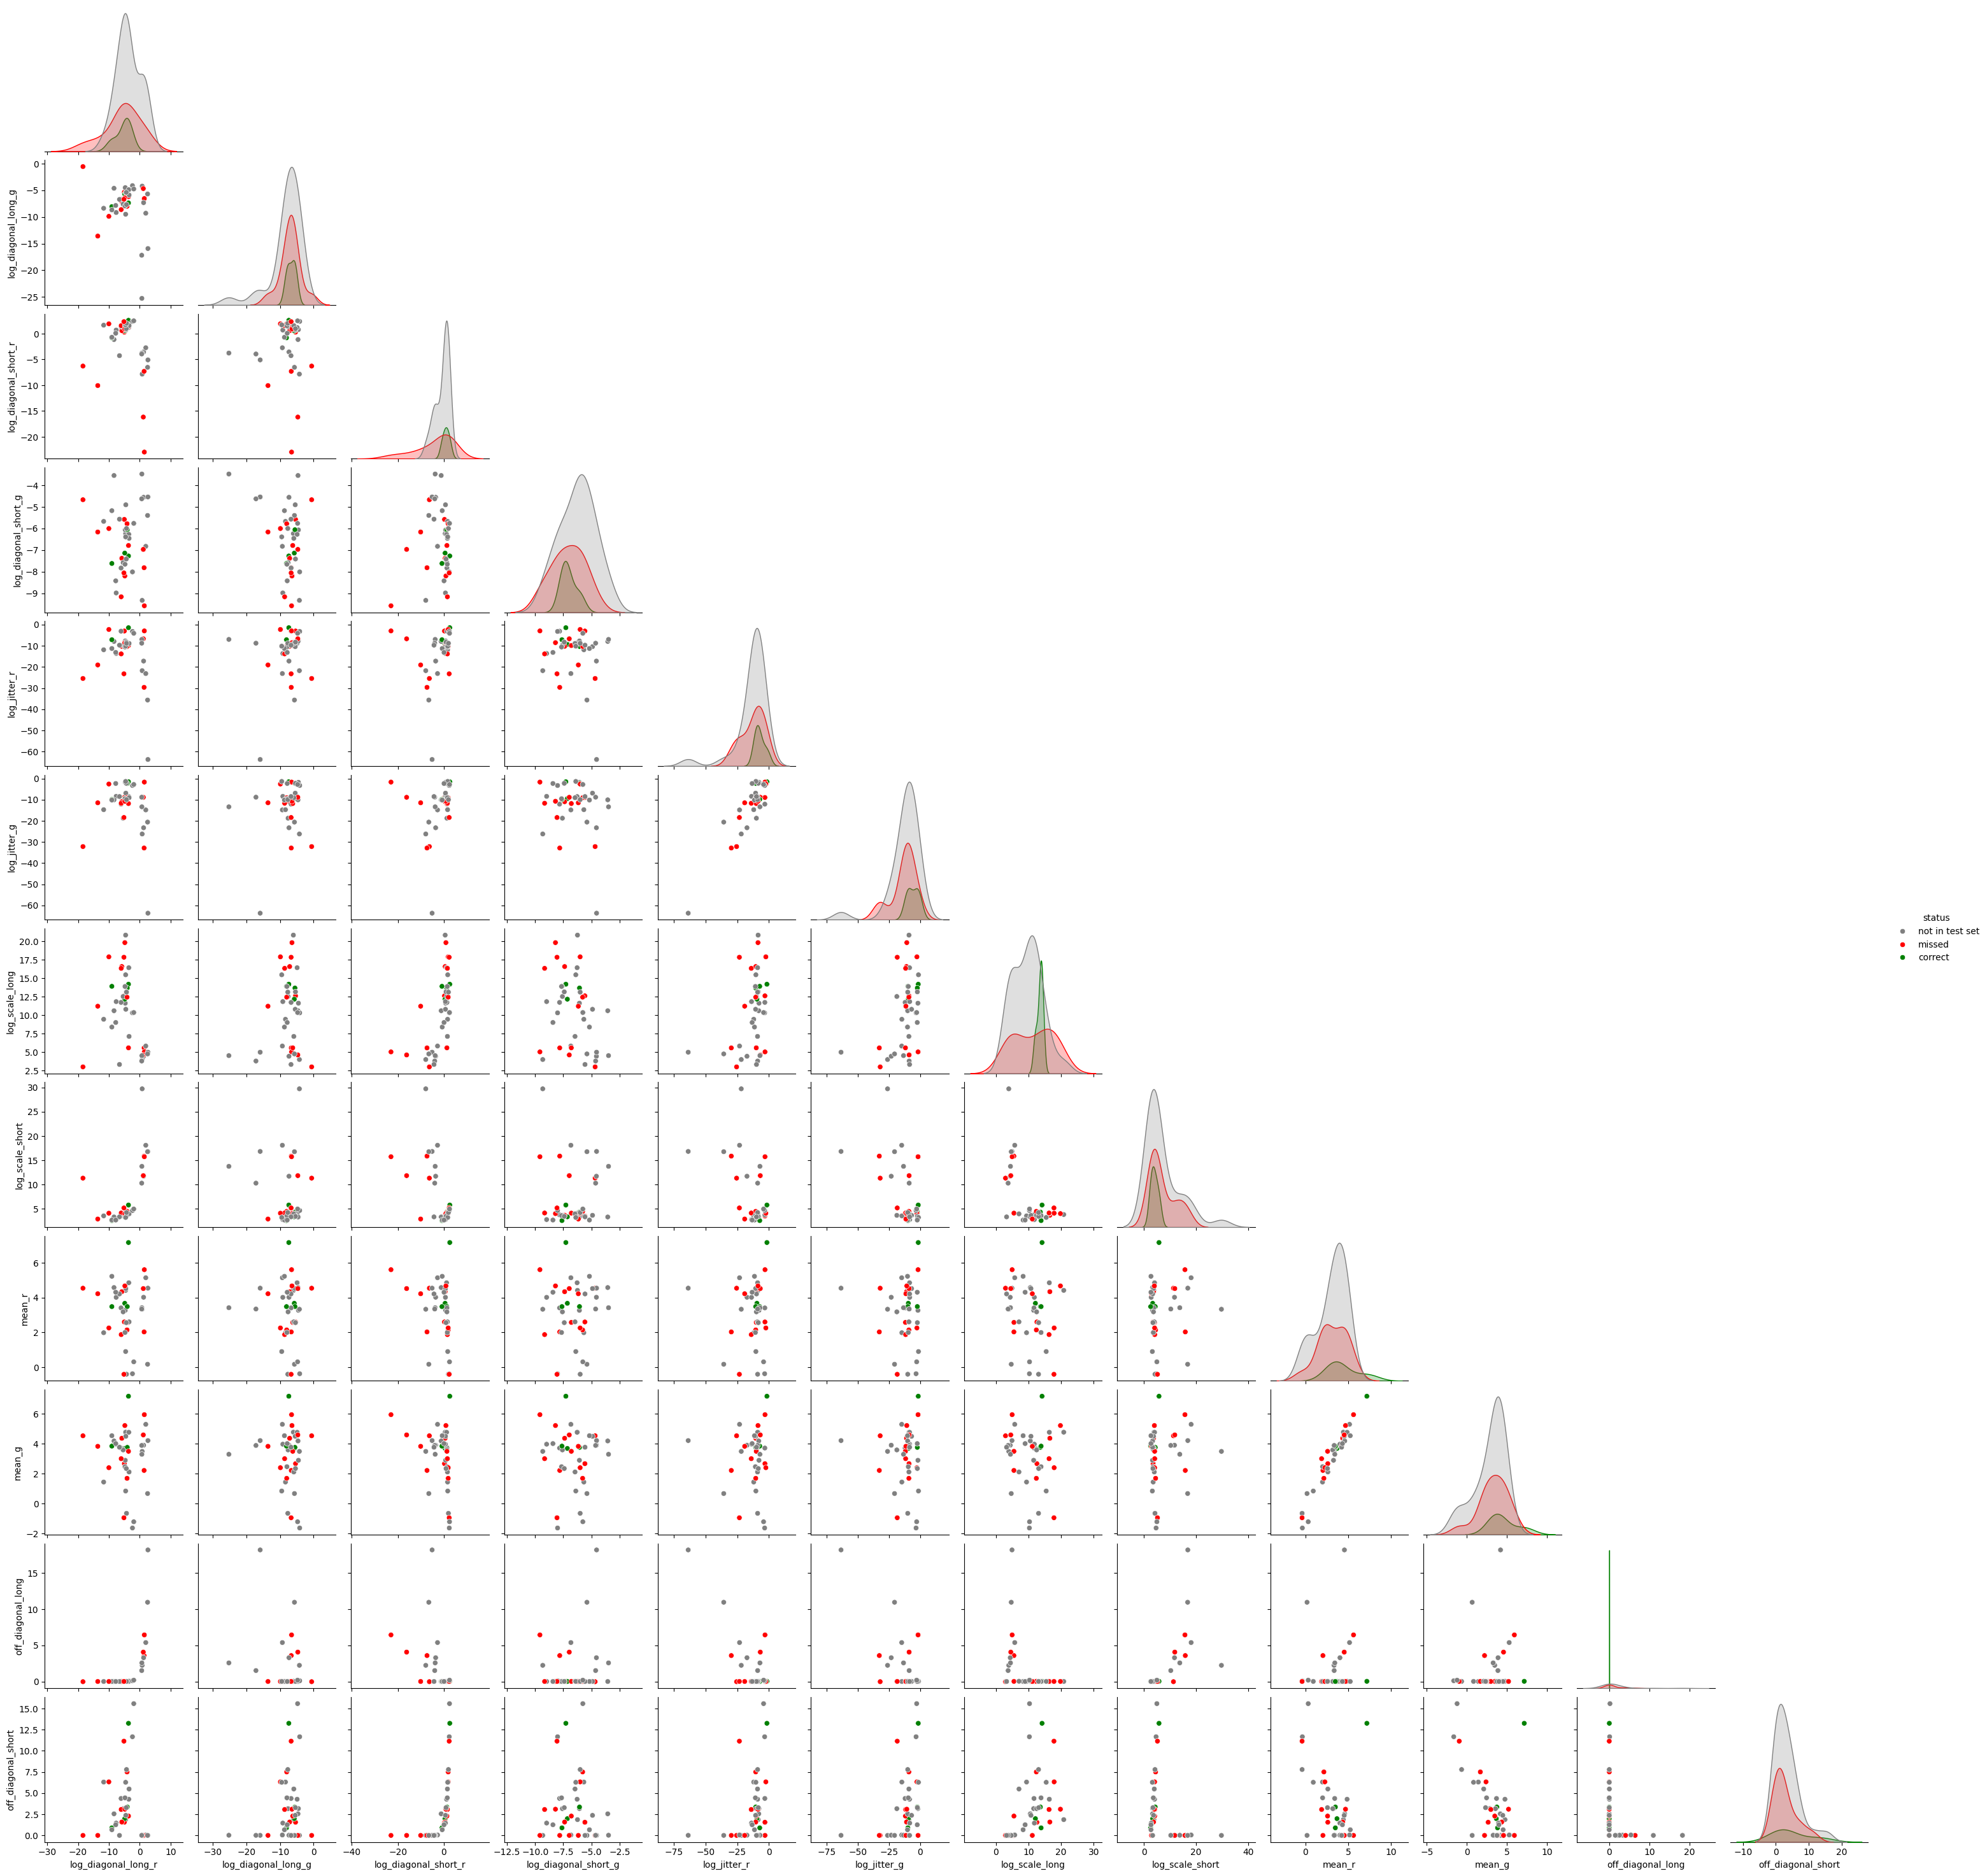

In [ ]:
sns.pairplot(df_ibn_filtered.drop(['Ibn'],axis=1),hue='status',palette=['gray','red','green'],corner=True)